In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip "/content/drive/MyDrive/Obstacle Detection/Iterations/sidewalk-model-20k-iter.zip" -d ""
!mv "/content/content/output" "/content"

Archive:  /content/drive/MyDrive/Obstacle Detection/Iterations/sidewalk-model-20k-iter.zip
   creating: content/output/
  inflating: content/output/metrics.json  
  inflating: content/output/events.out.tfevents.1660308827.766c8c993821.67.0  
  inflating: content/output/events.out.tfevents.1660385578.38b2e1e61138.71.0  
 extracting: content/output/last_checkpoint  
  inflating: content/output/model_0004999.pth  
  inflating: content/output/events.out.tfevents.1660276295.bba4196d132a.672.3  
  inflating: content/output/events.out.tfevents.1660299686.0a19bd75c1a3.72.0  
  inflating: content/output/model_0009999.pth  
  inflating: content/output/events.out.tfevents.1660304234.0a19bd75c1a3.72.1  
  inflating: content/output/model_0014999.pth  
  inflating: content/output/events.out.tfevents.1660399169.d728458ea2e1.895.0  
  inflating: content/output/events.out.tfevents.1660268036.bba4196d132a.672.0  
  inflating: content/output/model_final.pth  
  inflating: content/output/events.out.tfeven

In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 39.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=088c4d5f38d2166f72fd568d2f82b894826c6f13c096977fb2b4e0dfcd8adb7d
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-3o_r211d
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-3o_r211d
     |████████████████████████████████| 50 kB 7.4 MB/s 
     |████████████████████████████████| 79 kB

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2.data.datasets import register_coco_instances
for d in ["train", "test"]:
    register_coco_instances(f"segmentation_{d}", {}, f"/content/drive/MyDrive/Obstacle Detection/datasets/{d}_annotations.coco.json", f"/content/drive/MyDrive/Obstacle Detection/datasets/{d}")

# Check if all annotations in the registered training set have the segmentation field
from detectron2.data import DatasetCatalog

dataset_dicts_train = DatasetCatalog.get('segmentation_train')

for d in dataset_dicts_train:
    for obj in d['annotations']:
        if 'segmentation' not in obj:
            print(f'{d["file_name"]} has an annotation with no segmentation field')

ModuleNotFoundError: ignored

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("segmentation_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8  
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 20000    
cfg.SOLVER.STEPS = []       
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 15
cfg.MODEL.DEVICE = "cuda"

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[08/16 02:27:06 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir output

WARNING [08/16 02:30:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/16 02:30:31 d2.data.datasets.coco]: Loaded 30 images in COCO format from /content/drive/MyDrive/Obstacle Detection/datasets/test_annotations.coco.json


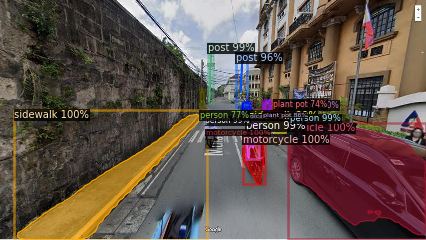

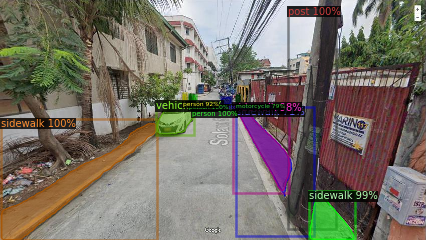

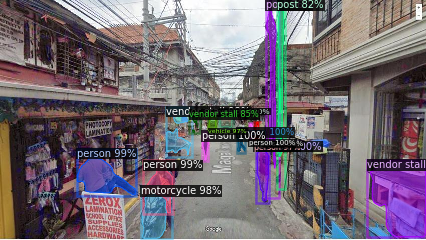

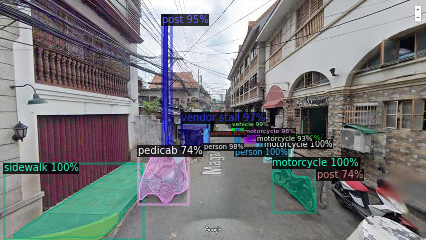

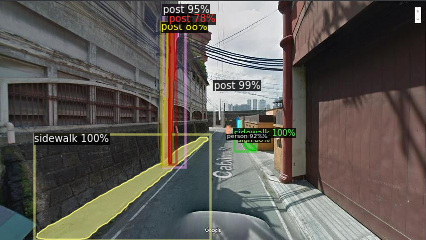

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from detectron2.utils.visualizer import ColorMode

segmentation_train_metadata = MetadataCatalog.get("segmentation_test")
dataset_dicts = DatasetCatalog.get("segmentation_test")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=segmentation_train_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.SEGMENTATION   
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# evaluating the model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("segmentation_train", output_dir="/content/drive/MyDrive/Colab Notebooks/datasets")
val_loader = build_detection_test_loader(cfg, "segmentation_train")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [08/14 10:08:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/14 10:08:31 d2.data.datasets.coco]: Loaded 746 images in COCO format from /content/drive/MyDrive/Obstacle Detection/Augmented/Both/train_annotations.coco.json
[08/14 10:08:31 d2.data.build]: Distribution of instances among all 15 categories:
|  category  | #instances   |  category  | #instances   |   category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:------------:|:-------------|
|  Obstacle  | 0            |  bicycle   | 93           |    debris    | 392          |
| motorcycle | 608          |  pedicab   | 180          |    person    | 1938         |
| plant pot  | 548          |    post    | 1102         |   pothole    | 18           |
|  sidewalk  | 1300         |    sign    | 321          |     tree     | 225          |
|  tricycle  | 33           |  vehicle   | 2262         | vendor stall | 199          |


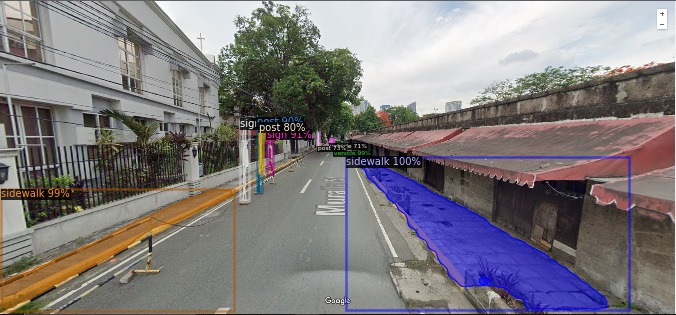

In [ ]:
# testing the model on actual sidewalk pictures
im = cv2.imread('/content/drive/MyDrive/Done na/Map 2/muralla st/m16.png')
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1], metadata=segmentation_train_metadata, scale=0.5, instance_mode=ColorMode.SEGMENTATION)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])